In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [279]:
languages = ['C']
d ={}
b={}
for language in languages:
    d[language] =[]
    b[language]=[]

In [280]:
def plot_roc_curve(model, X_test, y_test, model_name, color):
    # Get the probability predictions for the positive class
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[LightGBM] [Info] Number of positive: 40, number of negative: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30
[LightGBM] [Info] Number of data points in the train set: 89, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449438 -> initscore=-0.202941
[LightGBM] [Info] Start training from score -0.202941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

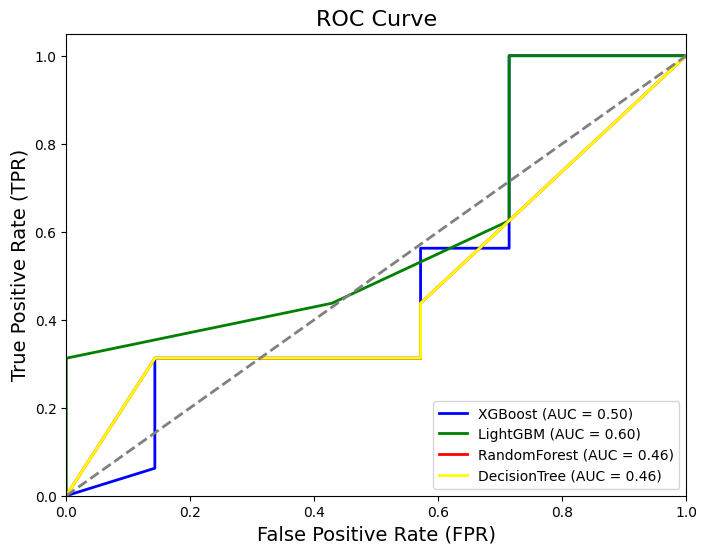

In [281]:
for language in languages:
    # print(language)
    df = pd.read_csv(f'data/new/language2/{language}.csv')
    labels=['low','high']

    df[f'{language}_wiki_label'] = df[f'{language}_wiki_label'].astype('category')
    df[f'{language}_wiki_label_encoded'] = df[f'{language}_wiki_label'].cat.codes
    X = df[[f'{language}_tiobe']]
    y = df[f'{language}_wiki_label_encoded'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # model = RandomForestClassifier(random_state=42)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    # rf_cv_scores = cross_val_score(model, X, y, cv=stratified_cv, scoring='accuracy') 
    # d[language].append(rf_cv_scores.mean())
    # print(classification_report(y_test, y_pred, target_names=labels))

    stratified_cv = StratifiedKFold(n_splits=10)

    rf_model = RandomForestClassifier(random_state=42)
    param_grid_rf = {
        'n_estimators': [100, 200, 300],       
        'max_depth': [None, 10, 20, 30],      
        'min_samples_split': [2, 5, 10],      
        'min_samples_leaf': [1, 2, 4],     
        'bootstrap': [True, False]      
    }
    grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=stratified_cv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)
    # print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)
    # print("Best Cross-Validation Score:", grid_search_rf.best_score_)
    best_rf_model = grid_search_rf.best_estimator_
    y_pred_rf = best_rf_model.predict(X_test)
    # print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
    # print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))
    rf_cv_scores = cross_val_score(best_rf_model, X, y, cv=stratified_cv, scoring='accuracy') 
    d[language].append(rf_cv_scores.mean())
    b[language].append(grid_search_rf.best_score_)


    dt_model = DecisionTreeClassifier(random_state=42)
    param_grid_dt = {
        'criterion': ['gini', 'entropy'],      
        'max_depth': [None, 10, 20, 30],       
        'min_samples_split': [2, 5, 10],       
        'min_samples_leaf': [1, 2, 4],         
        'splitter': ['best', 'random']         
    }
    grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=stratified_cv, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search_dt.fit(X_train, y_train)
    # print("Best Hyperparameters for Decision Tree:", grid_search_dt.best_params_)
    # print("Best Cross-Validation Score:", grid_search_dt.best_score_)
    best_dt_model = grid_search_dt.best_estimator_
    y_pred_dt = best_dt_model.predict(X_test)
    # print("Decision Tree Test Accuracy:", accuracy_score(y_test, y_pred_dt))
    # print("Classification Report for Decision Tree:\n", classification_report(y_test, y_pred_dt))
    dt_cv_scores = cross_val_score(best_dt_model, X, y, cv=stratified_cv, scoring='accuracy') 
    d[language].append(dt_cv_scores.mean())
    b[language].append(grid_search_dt.best_score_)


    xgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_weight': [1, 2]
    }
    xgb_model = XGBClassifier()
    xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1, verbose=1)
    xgb_grid_search.fit(X_train, y_train)
    # print("Best Hyperparameters for XGBoost: ", xgb_grid_search.best_params_)
    # print("Best Cross-Validation Score for XGBoost: ", xgb_grid_search.best_score_)
    best_xgb_model = xgb_grid_search.best_estimator_
    y_pred_xgb = best_xgb_model.predict(X_test)
    # print("XGBoost Test Accuracy:", accuracy_score(y_test, y_pred_xgb))
    # print("Classification Report for XgBoost:\n", classification_report(y_test, y_pred_xgb))
    xgb_cv_scores = cross_val_score(best_xgb_model, X, y, cv=stratified_cv, scoring='accuracy') 
    d[language].append(xgb_cv_scores.mean())
    b[language].append(xgb_grid_search.best_score_)



    lgb_param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'min_child_samples': [10, 20]
    }
    lgb_model = LGBMClassifier()
    lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=stratified_cv, scoring='accuracy', n_jobs=-1, verbose=1)
    lgb_grid_search.fit(X_train, y_train)
    # print("Best Hyperparameters for LightGBM: ", lgb_grid_search.best_params_)
    # print("Best Cross-Validation Score for LightGBM: ", lgb_grid_search.best_score_)
    best_lgb_model = lgb_grid_search.best_estimator_
    y_pred_lgb = best_lgb_model.predict(X_test)
    # print("LGBM Test Accuracy:", accuracy_score(y_test, y_pred_lgb))
    # print("Classification Report for LGBM:\n", classification_report(y_test, y_pred_lgb))
    lgb_cv_scores = cross_val_score(best_lgb_model, X, y, cv=stratified_cv, scoring='accuracy') 
    d[language].append(lgb_cv_scores.mean())
    b[language].append(lgb_grid_search.best_score_)

    
    plt.figure(figsize=(8, 6))

    plot_roc_curve(best_xgb_model, X_test, y_test, 'XGBoost', color='blue')
    plot_roc_curve(best_lgb_model, X_test, y_test, 'LightGBM', color='green')
    plot_roc_curve(best_rf_model, X_test, y_test, 'RandomForest', color='red')
    plot_roc_curve(best_dt_model, X_test, y_test, 'DecisionTree', color='yellow')


    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (chance level)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()


    # model = DecisionTreeClassifier(random_state=42)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # accuracy = accuracy_score(y_test, y_pred)
    # dt_cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy') 
    # d[language].append(dt_cv_scores.mean())
    # print(classification_report(y_test, y_pred, target_names=labels))


    # xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
    # xgb_model.fit(X_train, y_train)
    # y_pred_xgb = xgb_model.predict(X_test)
    # xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    # xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
    # d[language].append(xgb_cv_scores.mean())
    # print(classification_report(y_test, y_pred, target_names=labels))

    
    # lgbm_model = LGBMClassifier(random_state=42)
    # lgbm_model.fit(X_train, y_train)
    # y_pred_lgbm = lgbm_model.predict(X_test)
    # lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
    # lgbm_cv_scores = cross_val_score(lgbm_model, X, y, cv=5, scoring='accuracy')
    # d[language].append(lgbm_cv_scores.mean())
    # print(classification_report(y_test, y_pred, target_names=labels))
    


In [282]:
for key, val in d.items():
    print(f'{key} : ', end='')
    for v in val:
        print("{:.2f}".format(v), end=',  ')
    print()
    

C : 0.63,  0.63,  0.59,  0.57,  


In [283]:
for key, val in b.items():
    print(f'{key} : ', end='')
    for v in val:
        print("{:.2f}".format(v), end=',  ')
    print()
    

C : 0.68,  0.68,  0.63,  0.60,  
